# Importing libs and reading data.

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import re  
from collections import defaultdict 
import spacy  
from time import time
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
import seaborn as sns
sns.set_style("darkgrid")

import itertools
from wordcloud import WordCloud
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.layers import Embedding

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

nlp = spacy.load('en_core_web_sm')
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataframe = pd.read_csv('/kaggle/input/twitter-sentiment-dataset/Twitter_Data.csv')
dataframe.head(2)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0


In [3]:
dataframe.isnull().sum()

clean_text    4
category      7
dtype: int64

In [4]:
dataframe = dataframe.dropna().reset_index(drop=True)
dataframe.isnull().sum()

clean_text    0
category      0
dtype: int64

In [5]:
dataframe['clean_text']= dataframe['clean_text'].str.lower()

In [6]:
# removing URLs

def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataframe['clean_text'] = dataframe['clean_text'].apply(lambda x: cleaning_URLs(x))

In [7]:
# removing numbers 

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataframe['clean_text'] = dataframe['clean_text'].apply(lambda x: cleaning_numbers(x))

In [8]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

# remove twitter handles (@user)

dataframe['clean_text'] = np.vectorize(remove_pattern)(dataframe['clean_text'], "@[\w]*")

In [9]:
# remove special characters, numbers and punctuations

dataframe['clean_text'] = dataframe['clean_text'].str.replace("[^a-zA-Z#]", " ")
dataframe.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,clean_text,category
0,when modi promised minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [10]:
# below code taken from https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [11]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in dataframe['clean_text'])

In [12]:
t = time()
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))
dataframe.head(5)

Time to clean up everything: 7.84 mins


,clean_text,category
0,when modi promised minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [13]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
df_clean.head(5)

(154006, 1)


,clean
0,modi promise minimum government maximum govern...
1,talk nonsense continue drama vote modi
2,vote modi welcome bjp tell rahul main campaign...
3,ask supporter prefix chowkidar name modi great...
4,answer powerful world leader today trump putin...


91352


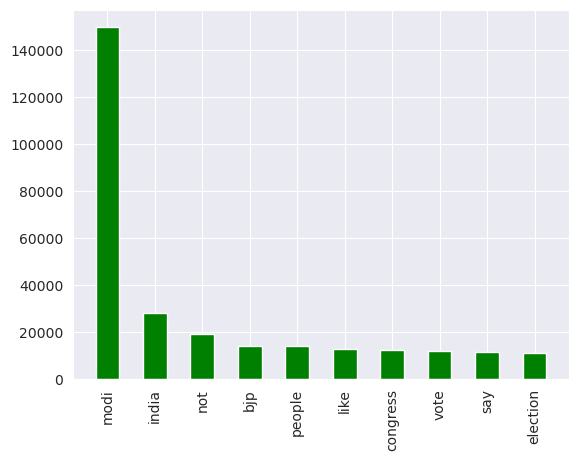

In [14]:
# How many unique words in the vocabulary?

all_words = " ".join([sentence for sentence in df_clean['clean']])
all_words = all_words.split()

freq_dict = {}
for word in all_words:
    # set the default value to 0
    freq_dict.setdefault(word, 0)
    # increment the value by 1
    freq_dict[word] += 1

voc_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))
print(len(voc_freq_dict))
hist_plot = dict(itertools.islice(voc_freq_dict.items(), 10))
plt.bar(hist_plot.keys(), hist_plot.values(), width=0.5, color='g')
plt.xticks(rotation=90)
plt.show()

Even after removing the stop words using spicy, we still have some words like 'not' in the dataset and those can be removed using NLTK. 

In [15]:
# Removing stop words using nltk lib

#Tokenization of text
tokenizer=ToktokTokenizer() 

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

#Removing standard english stopwords like prepositions, adverbs
stop = set(stopwords.words('english'))
print("NLTK stop word lists \n")
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


NLTK stop word lists 

{'my', 'weren', "shan't", 'but', 'at', 'very', 'which', 'such', "needn't", "hadn't", 'into', "hasn't", 'shan', 'them', 'with', 'she', 'now', 'be', 'most', "she's", 'other', 'don', "should've", 't', 'above', 'below', 'out', 'her', 'its', 'whom', 'until', 'you', 'that', 'just', 'our', "didn't", 'some', 'can', 'ourselves', 'on', 'because', "shouldn't", "you'll", 'no', 'own', 'we', "wouldn't", 'having', 'who', 'what', 'in', 'had', 'against', "isn't", 'mightn', 'there', 'yourselves', 'should', 'hers', 'm', 'couldn', 'doesn', 'under', "doesn't", 'between', 'have', 'those', 'too', 'the', 'theirs', 'here', 'through', 'themselves', 'was', 'does', 'few', 'so', 'o', 'are', 'for', 'ours', 'not', 'll', 'why', 'won', 'am', 'do', 'while', "haven't", 'myself', 'a', 'shouldn', 'he', 'nor', 'by', 'will', 'hadn', 'isn', 'as', "aren't", 'i', 'from', 'off', 'ma', 'haven', 'of', "it's", 'his', 'after', 'further', "mightn't", 'yourself', 'itself', 'they', "couldn't", 'been', 'once', 'v

In [16]:
df_clean['clean'] = df_clean['clean'].apply(remove_stopwords)
df_clean.head()

,clean
0,modi promise minimum government maximum govern...
1,talk nonsense continue drama vote modi
2,vote modi welcome bjp tell rahul main campaign...
3,ask supporter prefix chowkidar name modi great...
4,answer powerful world leader today trump putin...


In [17]:
# How many unique words in the vocabulary?

all_words = " ".join([sentence for sentence in df_clean['clean']])
all_words = all_words.split()

freq_dict = {}
for word in all_words:
    # set the default value to 0
    freq_dict.setdefault(word, 0)
    # increment the value by 1
    freq_dict[word] += 1

voc_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse = True))
print(len(voc_freq_dict))

91284


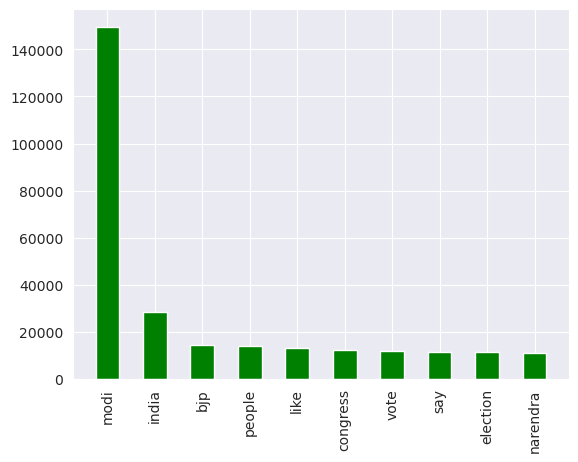

In [18]:
# top 10 words with frequency.

hist_plot = dict(itertools.islice(voc_freq_dict.items(), 10))
plt.bar(hist_plot.keys(), hist_plot.values(), width=0.5, color='g')
plt.xticks(rotation=90)
plt.show()

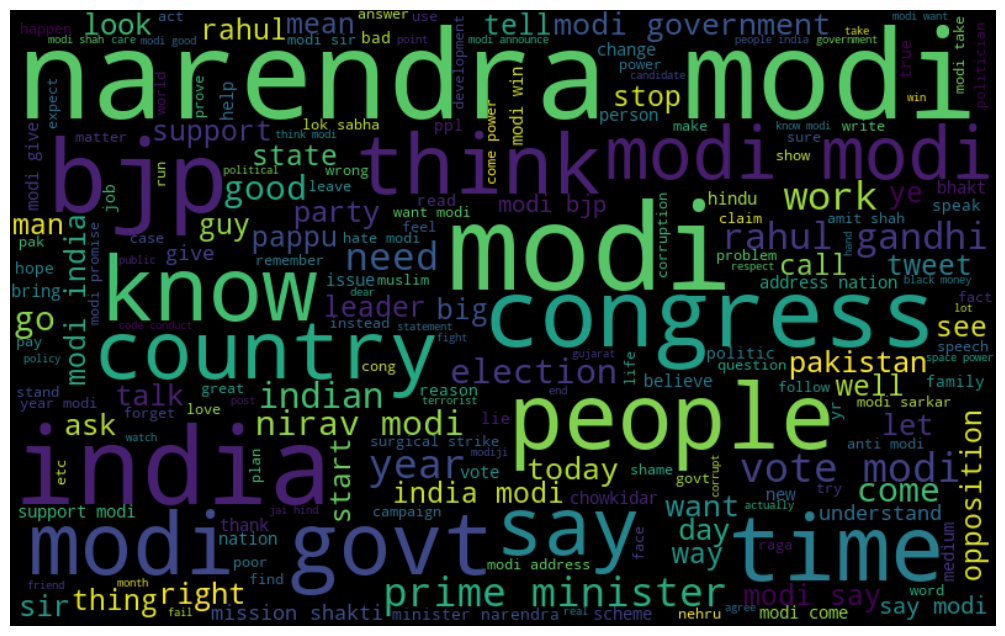

In [19]:
# visualize the frequent words

all_words = " ".join([sentence for sentence in df_clean['clean']])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
sent = [row.split() for row in df_clean['clean']]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [21]:
all_sentances = ' '
j = 0
for i in sentences:
    check = ' '.join(i)  
    all_sentances = ' '.join([all_sentances, check])

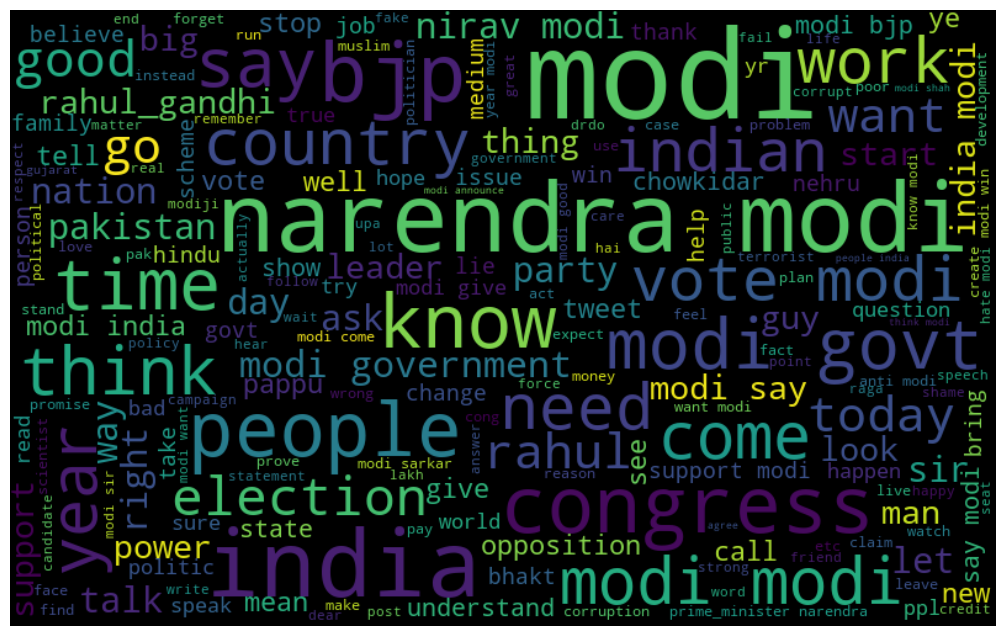

In [22]:
# wordcloud freq graph after bigram.

all_sentances = ' '
j = 0
for i in sentences:
    check = ' '.join(i)  
    all_sentances = ' '.join([all_sentances, check])
    
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_sentances)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Model Training : Gensim Word2Vec Implementation

In [23]:
# Count the number of cores in a computer.
cores = multiprocessing.cpu_count() 
print(cores)

4


## Train a simple model

In [24]:
model = Word2Vec(
    sentences = sentences,
    compute_loss=True
)
model.get_latest_training_loss()

8373251.5

In [25]:
# Here it builds the vocabulary from a sequence of sentences and thus later can be used in the model.

model.build_vocab(sentences, progress_per=10000)
model.corpus_count

154006

In [26]:
class MetricCallback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self, every=10):
        self.myloss = []
        self.epoch = 0
        self.every = every

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.myloss.append(loss)
        else:
            self.myloss.append(loss - self.loss_previous_step)
        if self.epoch % self.every == 0:
            print(f'Loss after epoch {self.epoch}: {self.myloss[-1]}') 
        self.epoch += 1
        self.loss_previous_step = loss


## Model with hyper parameters

### Model with 5 epochs

Loss after epoch 0: 1988247.625
Loss after epoch 1: 1681490.125
Loss after epoch 2: 1427099.75
Loss after epoch 3: 1281741.0
Loss after epoch 4: 1299858.0


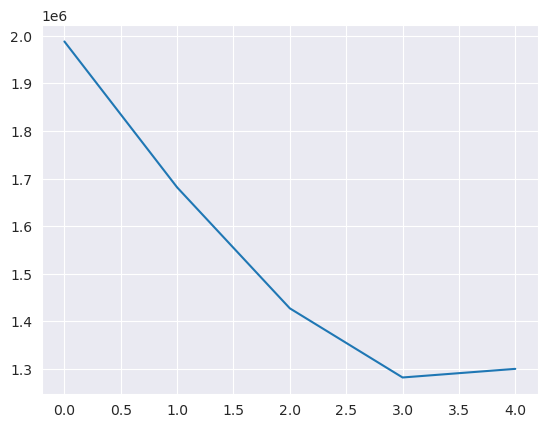

In [27]:
metric = MetricCallback(every=1)
model = Word2Vec(
    sentences = sentences,
    vector_size=300,
    max_vocab_size = model.corpus_count,
    compute_loss=True,
    callbacks=[metric],
    alpha=0.03,
    min_alpha=0.0007, 
    workers=cores-1
)
plt.plot(metric.myloss)

### Model with 10 epochs

Loss after epoch 0: 1975365.875
Loss after epoch 1: 1608093.375
Loss after epoch 2: 1464099.25
Loss after epoch 3: 1287843.5
Loss after epoch 4: 1214267.0
Loss after epoch 5: 1150106.0
Loss after epoch 6: 990156.0
Loss after epoch 7: 1014763.0
Loss after epoch 8: 1006956.0
Loss after epoch 9: 997461.0


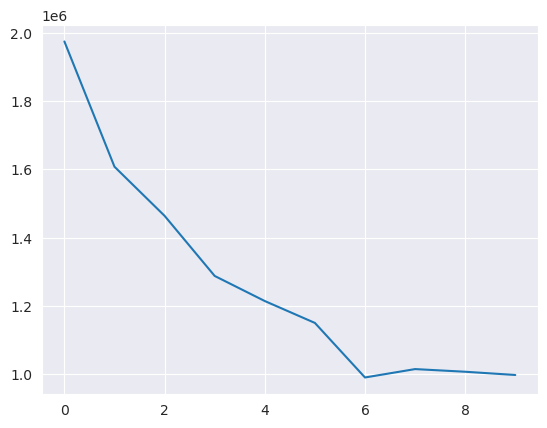

In [28]:
metric = MetricCallback(every=1)
model = Word2Vec(
    sentences = sentences,
    vector_size=300,
    max_vocab_size = model.corpus_count,
    compute_loss=True,
    callbacks=[metric],
    alpha=0.03,
    min_alpha=0.0007, 
    workers=cores-1,
    epochs = 10,
)
plt.plot(metric.myloss)

After 6 epochs model loss is quite unstable and the loss value obtained at epoch 10 is least and optimal. will freeze this model for further evaluation.

# Model Evaluation

## Checking the most similar positive and negative words  

In [29]:
# the data have lot of political info on India, checkig the positive similarity with word India. 

model.wv.most_similar(positive=['india'])

[('country', 0.6122025847434998),
 ('prosperous', 0.4937443733215332),
 ('indias', 0.46610602736473083),
 ('super_power', 0.4486863613128662),
 ('nation', 0.42908361554145813),
 ('countrywe', 0.4258113503456116),
 ('county', 0.41286009550094604),
 ('superpower', 0.410570353269577),
 ('corruptionfree', 0.4054722785949707),
 ('attain', 0.40524542331695557)]

In [30]:
# negative similarity with word India. 

model.wv.most_similar(negative=['india'])

[('patra', 0.3922622501850128),
 ('verma', 0.37338632345199585),
 ('kunal', 0.3569897711277008),
 ('tick', 0.3559143841266632),
 ('sharma', 0.3514501452445984),
 ('shekhar', 0.3495651185512543),
 ('mishra', 0.34953466057777405),
 ('shashi', 0.34887146949768066),
 ('alok', 0.34451690316200256),
 ('bachchan', 0.34126392006874084)]

In [31]:
model.wv.most_similar(positive=['bjp'])

[('bjps', 0.5763956904411316),
 ('dmk', 0.5246635675430298),
 ('shiv_sena', 0.5164492130279541),
 ('regional_party', 0.5113227963447571),
 ('cadre', 0.5098848342895508),
 ('jds', 0.5085133910179138),
 ('trs', 0.5029745101928711),
 ('ncp', 0.502275288105011),
 ('bjd', 0.49256089329719543),
 ('ally', 0.4881308376789093)]

In [32]:
model.wv.most_similar(negative=['bjp'])

[('classic', 0.36146244406700134),
 ('launcher', 0.3609059751033783),
 ('candy', 0.3446234464645386),
 ('blockchain', 0.3427935838699341),
 ('mild', 0.34112608432769775),
 ('dhoom', 0.3236980140209198),
 ('dish', 0.3195292353630066),
 ('mahabharat', 0.3174445629119873),
 ('shoot', 0.3146505355834961),
 ('kumkum', 0.3095659017562866)]

In [33]:
model.wv.most_similar(positive=['narendramodi'])

[('koraput', 0.7466253042221069),
 ('financialxpress', 0.743855357170105),
 ('pmoindia', 0.7311522364616394),
 ('watch_live', 0.7173112630844116),
 ('aalo', 0.713368833065033),
 ('videoconference', 0.7104872465133667),
 ('late_update', 0.7022518515586853),
 ('wednesday', 0.6937574744224548),
 ('jeypore', 0.6936001777648926),
 ('hema_malini', 0.6935893297195435)]

In [34]:
model.wv.most_similar(negative=['election'])

[('sagarika', 0.30674463510513306),
 ('candy', 0.3048442304134369),
 ('sen', 0.30478769540786743),
 ('amartya', 0.29023414850234985),
 ('prashant', 0.28537508845329285),
 ('kumkum', 0.2815898358821869),
 ('fake_degree', 0.2798704504966736),
 ('cigarette', 0.27716299891471863),
 ('degree_holder', 0.27329856157302856),
 ('marry', 0.2718023657798767)]

In [35]:
model.wv.most_similar(positive=['election'])

[('poll', 0.6488720178604126),
 ('general_election', 0.5533764362335205),
 ('unlikely', 0.44714459776878357),
 ('election_campaign', 0.4442530870437622),
 ('electoral', 0.44143399596214294),
 ('polls', 0.4411778748035431),
 ('assembly_election', 0.4255896508693695),
 ('bypoll', 0.4186738133430481),
 ('elections', 0.4119737148284912),
 ('loksabha_election', 0.40931686758995056)]

In [36]:
# below code from https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 15 dimensions with PCA
    reduc = PCA(n_components=15).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


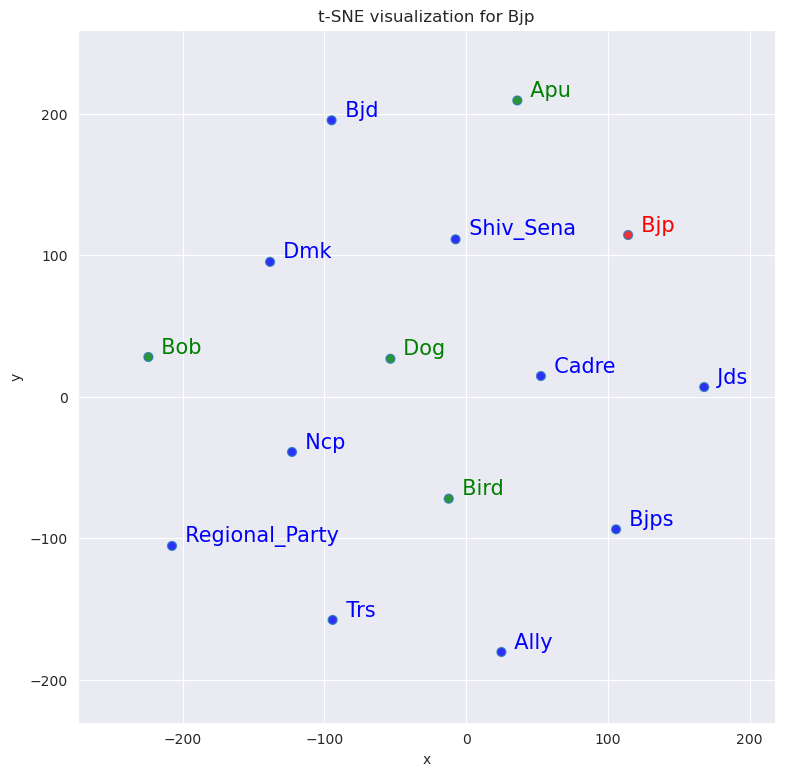

In [37]:
# checking Most similar words for bjp vs. 4 Random words:
# red : actual word
# green : random words
# blue :  most similar words
tsnescatterplot(model, 'bjp', ['dog', 'bird', 'bob', 'apu'])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


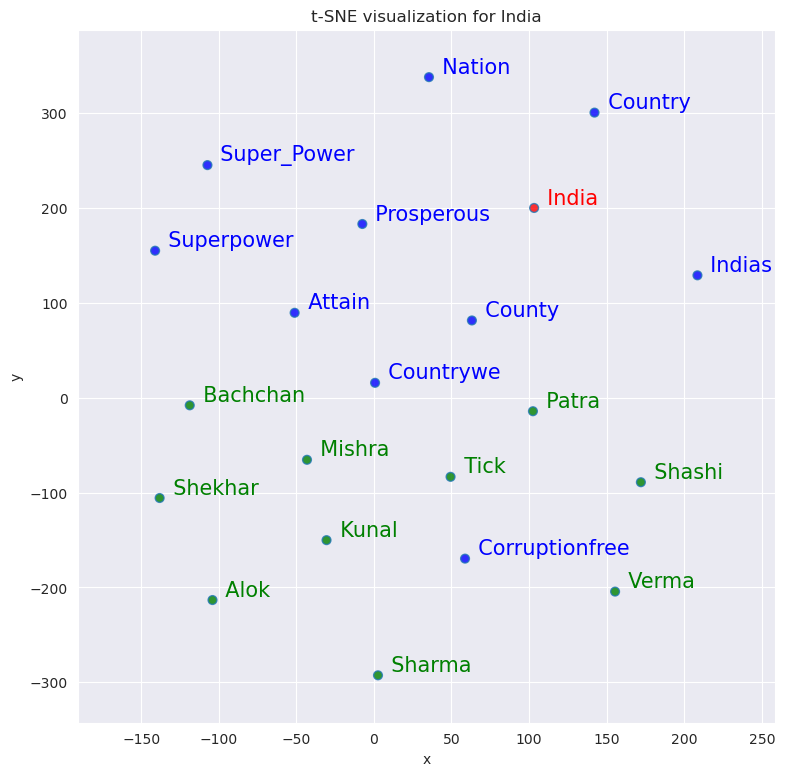

In [38]:
# checking Most similar and not similar words for India

tsnescatterplot(model, 'india', [i[0] for i in model.wv.most_similar(negative=["india"])])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


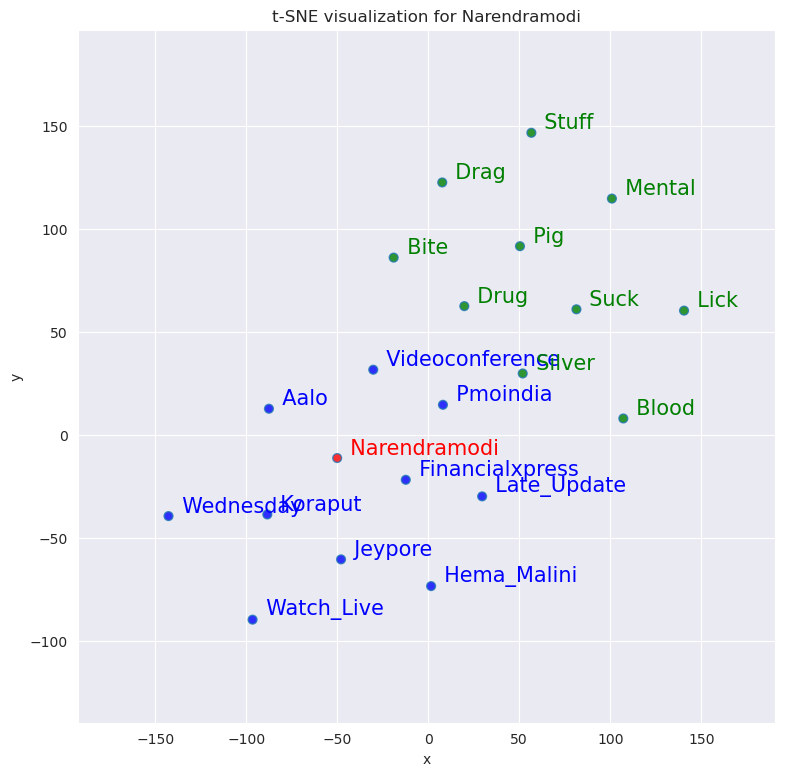

In [39]:
# checking Most similar and not similar words for BJP

tsnescatterplot(model, 'narendramodi', [i[0] for i in model.wv.most_similar(negative=["narendramodi"])])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


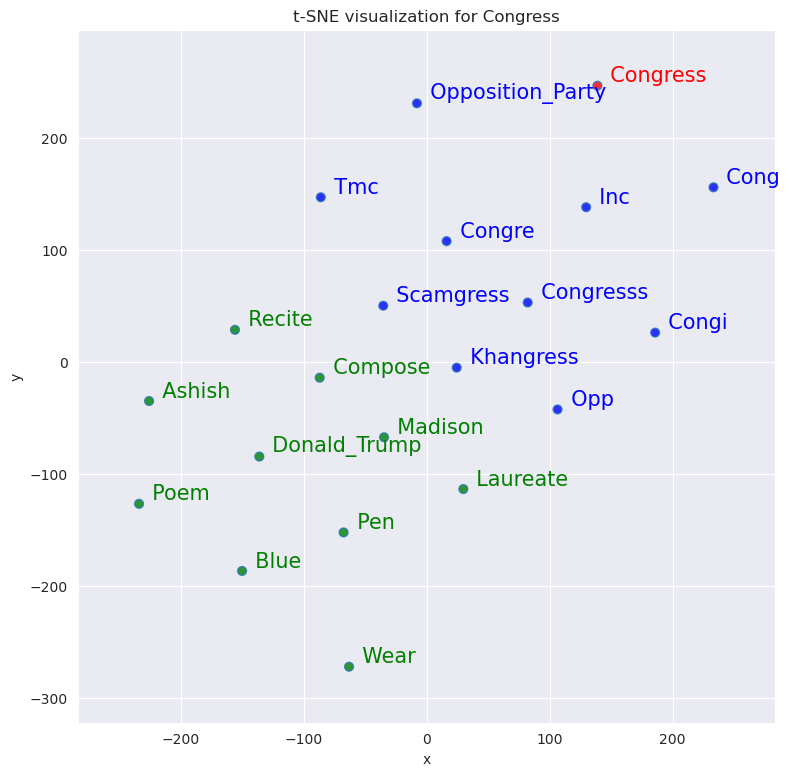

In [40]:
# checking Most similar and not similar words for congress

tsnescatterplot(model, 'congress', [i[0] for i in model.wv.most_similar(negative=["congress"])])

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


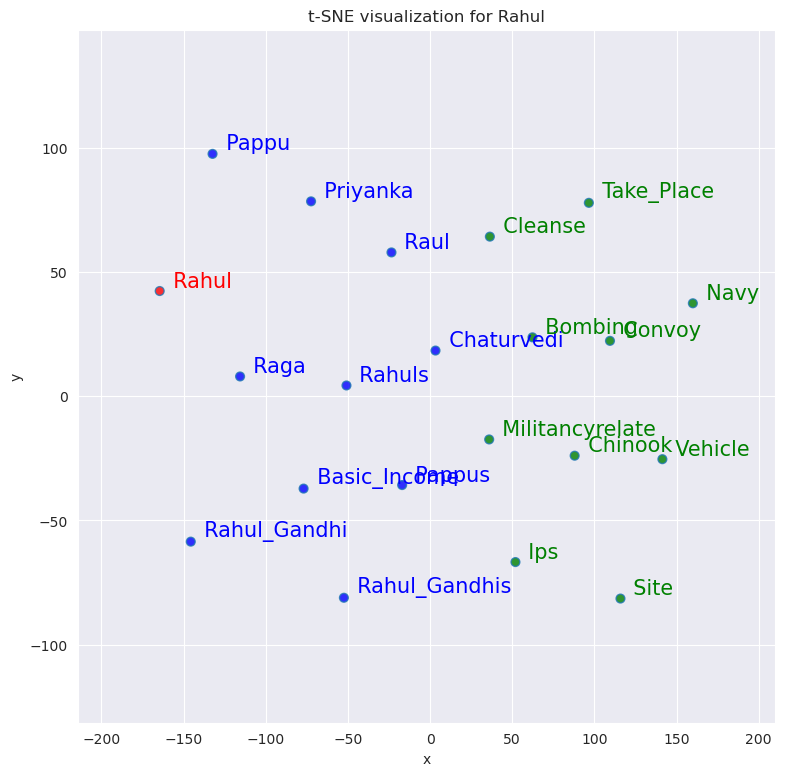

In [41]:
# checking Most similar and not similar words for rahul

tsnescatterplot(model, 'rahul', [i[0] for i in model.wv.most_similar(negative=["rahul"])])

# Save and load the model

In [42]:
# Save the model

model.save('tweet-election.w2v')

In [43]:
model = KeyedVectors.load('tweet-election.w2v')

In [44]:
model